<a href="https://colab.research.google.com/github/TottiPuc/Machine_learning/blob/master/NN_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicción de alquiler de bicicletas con NN en python


In [0]:
!pip install watermark

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas
import matplotlib
%matplotlib inline


In [11]:
%reload_ext watermark
%watermark -a "Christian Dayan Arcos Gordillo" --iversion

numpy      1.18.2
pandas     1.0.3
matplotlib 3.2.1
Christian Dayan Arcos Gordillo


#Cargando el dataset

In [0]:
from google.colab import files
files.upload()

In [0]:
df = pd.read_csv('hour.csv')

In [15]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


##Explorando los datos
Este dataset consta de un nuemor de ciclista para cada hora de cada dia desde el 1 de enero del 2011 al 31 de diciembre del 2012, y que son divididos en Casual, Registrado y resumidos en la variable CNT

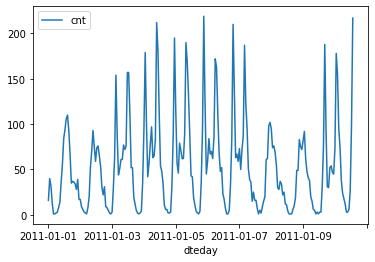

In [16]:
df[:24*10].plot(x='dteday', y = 'cnt')

La grafica muestra el registro de un ciclista durante los primeros 10 dias y como el alquila la bicicleta por horas. se puede ver picos altos ente semana y picos bajos en los fines de semana viendo el dataset se tiene  informaciones de temperatura humedad e velocidad del viento lo que porbablemente pueda afectar en los aluileres del cilcista 

##Creando variables Dummy

In [0]:
dummy_fields = ['season','weathersit','mnth','hr','weekday']

In [0]:
for each in dummy_fields:
  dummies =pd.get_dummies(df[each],prefix=each,drop_first=False)
  df=pd.concat([df,dummies],axis=1)

In [21]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
#eliminamos las variables que ya no sirven
columnas_para_eliminar = ['instant','dteday','season','weathersit','weekday','atemp','mnth','workingday','hr']

In [23]:
data =df.drop(columnas_para_eliminar,axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


##Normalizando las variables
para facilitar el entrenamiento y ajuste de la red es mejor normalizar y dejar en la misma escala todas las variables del dataset

In [0]:
features_numericas =['casual','registered','cnt','temp','hum','windspeed']

In [0]:
scaled_features ={}

In [0]:
for item in features_numericas:
  mean,std = data[item].mean(),data[item].std()
  scaled_features[item]=[mean,std]
  data.loc[:,item] = (data[item]-mean)/std

In [28]:
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


##Dividiendo el conjunto de datos en entrenamiento y teste

In [0]:
#como teste se usara los ultimos 21 dias del dataset
test_data = data[-21*24:]
data = data[:-21*24]

In [0]:
#separando las variables predictoras y las target
target_fields = ['cnt','casual','registered']
features,targets = data.drop(target_fields,axis=1),data[target_fields]
test_features, test_targets = test_data.drop(target_fields,axis=1),test_data[target_fields]

In [0]:
#finalmente el conjunto de entrenamiento lo dividimos de nuevo para validar durante el entrenamiento
#para eso mantenemos los ultimos 60 dias de los datos restantes 
train_features, train_targets = features[:-60*24],targets[:-60*24]
val_features, val_targets = features[-60*24:],targets[-60*24:]

##Creando la estructura de la Red Neuronal

In [0]:
class neural_net(object):

  def __init__(self,input_nodes,hidden_nodes,output_nodes,learning_rate,verbose=False):

    #definir el numero de neurones en cada capa
    self.input_nodes  = input_nodes
    self.hidden_nodes = hidden_nodes
    self.output_nodes = output_nodes
    self.learning_rate= learning_rate
    self.verbose=verbose

    #inicializar pesos capa inicial
    self.weights_input_to_hidden = np.random.normal(loc=0.0,scale=self.hidden_nodes**-0.5,size=(self.hidden_nodes, self.input_nodes))

    #iniciar pesos capa oculta
    self.weights_hidden_to_output = np.random.normal(loc=0.0,scale=self.output_nodes**-0.5,size=(self.output_nodes,self.hidden_nodes))

    if self.verbose:
      print("\n Red neuronal iniciada  con: \n input_nodes{} \n hidden_node{} \n output_nodes{} \learning_rate{}".format(self.input_nodes,self.hidden_nodes,self.output_nodes,self.learning_rate))

    self.hidden_layer_activation_function = lambda x : 1 /(1+np.exp(-x))
    self.hidden_layer_derivate_activation_function = lambda sigmoid: sigmoid*(1-sigmoid)
    self.output_layer_activation_function = lambda x : x
    self.output_layer_derivate_activation_function = lambda x: 1

    #activacion
    self.activation_function = self.hidden_layer_activation_function

  def forward_pass(self, inputs):

    #forward pass
    #operaciones de la primera capa
    hidden_inputs = np.dot(self.weights_input_to_hidden,inputs)
    hidden_outputs = self.hidden_layer_activation_function(hidden_inputs)

    #operaciones de la capa oculta
    final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
    final_outputs = self.output_layer_activation_function(final_inputs)

    return [hidden_inputs,hidden_outputs,final_inputs,final_outputs]

  def backward_pass(self,inputs,target, hidden_inputs,hidden_outputs,final_inputs,final_outputs):

    #backward pass
    #operaciones en la ultima capa
    output_errors= target - final_outputs
    output_grad = self.output_layer_derivate_activation_function(final_outputs)

    #operaciones del error hacia atras
    hidden_errors = output_errors * output_grad * self.weights_hidden_to_output
    hidden_grad = self.hidden_layer_derivate_activation_function(hidden_outputs)

    return [output_errors, hidden_errors,hidden_grad,output_grad]

  def train(self,inputs_list,targets_list):

    #convertir la lista de entrada en matriz 2D
    #print("antes",inputs_list)
    inputs = np.array(inputs_list,ndmin=2).T
    targets = np.array(targets_list,ndmin=2).T
    #print("despues",inputs)
    hidden_inputs, hidden_outputs, final_inputs,final_outputs= self.forward_pass(inputs)
    output_errors, hidden_errors,hidden_grad,output_grad = self.backward_pass(inputs,targets,hidden_inputs, hidden_outputs, final_inputs,final_outputs )

    #actualización de pesos
    self.weights_hidden_to_output += self.learning_rate * np.dot(output_errors*output_grad,hidden_outputs.T)
    self.weights_input_to_hidden += self.learning_rate * np.dot(hidden_errors.T*hidden_grad,inputs.T)


  def run(self, inputs_list):
    #ejecutar un paso para adelante por la red
    inputs = np.array(inputs_list,ndmin=2).T

    _,_,_,final_outputs = self.forward_pass(inputs)
    return final_outputs




In [0]:
def MSE(y,Y):
  return np.mean((y-Y)**2)


##Entrenamiento de la Red

In [59]:
import sys

#configurando hiperparametros
epochs = 3000
learning_rate = 0.1
hidden_nodes = 27
output_nodes=1

N_i = train_features.shape[1]
network = neural_net(N_i,hidden_nodes,output_nodes,learning_rate,True)

losses = {'train':[], 'validation':[]}

for e in range(epochs):
  #recorre un conjunto aleatorio de 128 registros del conjunto de entrenaimento
  batch = np.random.choice(train_features.index,size=128)
  for record, target in zip(train_features.iloc[batch].values,train_targets.iloc[batch]['cnt']):
    network.train(record,target)

  #Imprimimos el progreso de entrenamiento
  train_loss = MSE(network.run(train_features),train_targets['cnt'].values)
  val_loss = MSE(network.run(val_features),val_targets['cnt'].values)
  #[:4] numero de decimales que queremos
  sys.stdout.write('\rProgreso: ' + str(100 * e/float(epochs))[:4] \
                     + "% ... Erro no Treinamento: " + str(train_loss)[:5] \
                     + " ... Erro na Validação: " + str(val_loss)[:5])

  losses['train'].append(train_loss)
  losses['validation'].append(val_loss)


 Red neuronal iniciada  con: 
 input_nodes56 
 hidden_node27 
 output_nodes1 \learning_rate0.1
Progreso: 99.9% ... Erro no Treinamento: 0.050 ... Erro na Validação: 0.138

##Evaluacion de la red

(-0.04674117029783418, 0.5)

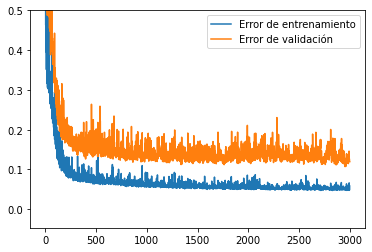

In [51]:
plt.plot(losses['train'], label = 'Error de entrenamiento')
plt.plot(losses['validation'], label = 'Error de validación')
plt.legend()
plt.ylim(ymax = 0.5)


##Predicciones

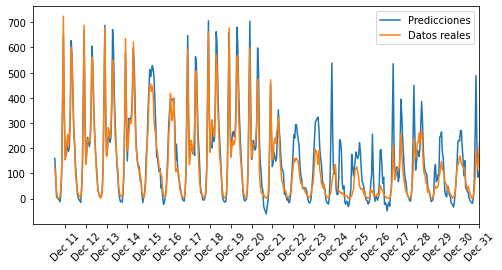

In [53]:
fig, ax = plt.subplots(figsize = (8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label = 'Predicciones')
ax.plot((test_targets['cnt']*std + mean).values, label='Datos reales')
ax.set_xlim(right = len(predictions))
ax.legend()

dates = pd.to_datetime(df.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)